# Feature EDA

## Notebook Setup

In [0]:
%pip install timezonefinder
%pip install tzfpy

Python interpreter will be restarted.
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Using cached cffi-1.15.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (441 kB)
  Using cached setuptools-65.6.3-py3-none-any.whl (1.2 MB)
  Created wheel for timezonefinder: filename=timezonefinder-6.1.8-cp39-cp39-manylinux_2_31_x86_64.whl size=45919980 sha256=cf48df1c8a0b7d15b5b26ec2ffca05fbbea2b508eb13d2344706a55001b84a6b
  Stored in directory: /home/spark-0ac99756-8832-42fc-b869-2e/.cache/pip/wheels/e6/43/c7/911bd3351ddf33fe74a51d98c51a2e6563ab046b77f37eeef7
Successfully built timezonefinder
  Attempting uninstall: setuptools
    Found existing installation: setuptools 58.0.4
    Not uninstalling setuptools at /usr/local/lib/

In [0]:
# General 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.express as px
import sys
from statistics import mean

# PySpark 
from pyspark.sql.functions import col,isnan,when,count
from pyspark.sql.functions import regexp_replace

# SQL Functions
from pyspark.sql import functions as f
from pyspark.sql.functions import monotonically_increasing_id, to_timestamp, to_utc_timestamp, to_date, udf
from pyspark.sql.functions import isnan, when, count, col, isnull, percent_rank, first
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType, FloatType, DecimalType
from pyspark.sql import SQLContext
from pyspark.sql.window import Window
from pyspark.streaming import StreamingContext
from pyspark.sql import Row
from functools import reduce
from pyspark.sql.functions import rand,col,when,concat,substring,lit,udf,lower,sum as ps_sum,count as ps_count,row_number
from pyspark.sql.window import *
from pyspark.sql import DataFrame
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import DenseMatrix, Vectors, VectorUDT, DenseVector, SparseVector
from pyspark.sql.functions import row_number
from pyspark.sql.functions import concat,col
from pyspark.sql.functions import date_format

# ML
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import ChiSquareTest

# Misc 
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from timezonefinder import TimezoneFinder
from tzfpy import get_tz

In [0]:
# Display and define where mids-w261 is located
data_BASE_DIR = "dbfs:/mnt/mids-w261/"
# display(dbutils.fs.ls(f"{data_BASE_DIR}"))

# Inspect the Mount's Final Project folder 
data_BASE_DIR = "dbfs:/mnt/mids-w261/datasets_final_project_2022/"
# display(dbutils.fs.ls(f"{data_BASE_DIR}"))

In [0]:
blob_container = "housestark" # The name of your container created in https://portal.azure.com
storage_account = "neilp" # The name of your Storage account created in https://portal.azure.com
secret_scope = "w261_s1g4" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "w261_s1g4_key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

In [0]:
spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

In [0]:
# df = spark.read.parquet(f"{blob_url}/df_main_fullClean")
df = spark.read.parquet(f"{blob_url}/df_main_fullClean_EDA")

## EDA

In [0]:
df = df.filter(col('Year') < 2021).filter(col('label') != 2)
display(df)

local_timestamp,timezone,scheduled_departure_UTC,rounded_depTimestamp,label,Year,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME_BLK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,dep_delay_15,DEP_DELAY_NEW,CANCELLED,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,elevation_ft,type,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DISTANCE,DISTANCE_GROUP,holiday,holiday_in2DayRange,C19,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,scheduled_departure_UTC_minus_1hr,scheduled_departure_UTC_add_2hr,origin_HourlyAltimeterSetting,origin_HourlyDewPointTemperature,origin_HourlyDryBulbTemperature,origin_HourlyPrecipitation,origin_HourlyPressureChange,origin_HourlyPressureTendency,origin_HourlyRelativeHumidity,origin_HourlySkyConditions,origin_HourlySkyConditions_SCT_cnt,origin_HourlySkyConditions_OVC_cnt,origin_HourlySkyConditions_FEW_cnt,origin_HourlySkyConditions_BKN_cnt,origin_HourlySkyConditions_VV_cnt,origin_HourlySkyConditions_SKC_cnt,origin_HourlySkyConditions_CLR_cnt,origin_HourlySeaLevelPressure,origin_HourlyStationPressure,origin_HourlyVisibility,origin_HourlyWetBulbTemperature,origin_HourlyWindDirection,origin_HourlyWindGustSpeed,origin_HourlyWindSpeed,dest_HourlyAltimeterSetting,dest_HourlyDewPointTemperature,dest_HourlyDryBulbTemperature,dest_HourlyPrecipitation,dest_HourlyPressureChange,dest_HourlyPressureTendency,dest_HourlyRelativeHumidity,dest_HourlySkyConditions,dest_HourlySkyConditions_SCT_cnt,dest_HourlySkyConditions_OVC_cnt,dest_HourlySkyConditions_FEW_cnt,dest_HourlySkyConditions_BKN_cnt,dest_HourlySkyConditions_VV_cnt,dest_HourlySkyConditions_SKC_cnt,dest_HourlySkyConditions_CLR_cnt,dest_HourlySeaLevelPressure,dest_HourlyStationPressure,dest_HourlyVisibility,dest_HourlyWetBulbTemperature,dest_HourlyWindDirection,dest_HourlyWindGustSpeed,dest_HourlyWindSpeed,roundedMonth,no_delays_last3m,no_cancellation_last3m,count_flights_last3m,perc_delays_last3m,perc_cancellation_last3m
2015-01-01T05:00:00.000+0000,America/Chicago,2015-01-01T11:00:00.000+0000,2015-01-01T11:00:00.000+0000,0,2015,1,1,1,4,0001-0559,US,N197UW,602,0,0,0,13930,ORD,"Chicago, IL",IL,672,large_airport,14107,PHX,"Phoenix, AZ",AZ,1440,6,1,1,0,0,0,0,0,0,2015-01-01T10:00:00.000+0000,2015-01-01T13:00:00.000+0000,30.02,5,14,0.0,999.0,999,67,CLR:00,0,0,0,0,0,0,1,30.06,29.3,10.0,12,240,22,14,30.04,6,15,0.0,999.0,999,67,SCT:04 250,1,0,0,0,0,0,0,30.08,29.32,10.0,13,240,23,13,2015-01-01T00:00:00.000+0000,23,0,96,0.23958333333333334,0.0
2015-01-01T05:56:00.000+0000,America/Chicago,2015-01-01T11:56:00.000+0000,2015-01-01T11:00:00.000+0000,0,2015,1,1,1,4,0001-0559,NK,N607NK,224,0,0,0,13930,ORD,"Chicago, IL",IL,672,large_airport,12953,LGA,"New York, NY",NY,733,3,1,1,0,0,0,0,0,0,2015-01-01T10:56:00.000+0000,2015-01-01T13:56:00.000+0000,30.02,5,14,0.0,999.0,999,67,CLR:00,0,0,0,0,0,0,1,30.06,29.3,10.0,12,240,22,14,30.04,6,15,0.0,999.0,999,67,SCT:04 250,1,0,0,0,0,0,0,30.08,29.32,10.0,13,240,23,13,2015-01-01T00:00:00.000+0000,40,4,126,0.31746031746031744,0.031746031746031744
2015-01-01T05:33:00.000+0000,America/Chicago,2015-01-01T11:33:00.000+0000,2015-01-01T11:00:00.000+0000,0,2015,1,1,1,4,0001-0559,UA,N66837,1167,0,7,0,13930,ORD,"Chicago, IL",IL,672,large_airport,11292,DEN,"Denver, CO",CO,888,4,1,1,0,0,0,0,0,0,2015-01-01T10:33:00.000+0000,2015-01-01T13:33:00.000+0000,30.02,5,14,0.0,999.0,999,67,CLR:00,0,0,0,0,0,0,1,30.06,29.3,10.0,12,240,22,14,30.04,6,15,0.0,999.0,999,67,SCT:04 250,1,0,0,0,0,0,0,30.08,29.32,10.0,13,240,23,13,2015-01-01T00:00:00.000+0000,27,0,77,0.35064935064935066,0.0
2015-01-01T05:10:00.000+0000,America/Chicago,2015-01-01T11:10:00.000+0000,2015-01-01T11:00:00.000+0000,0,2015,1,1,1,4,0001-0559,UA,N30401,1500,0,4,0,13930,ORD,"Chicago, IL",IL,672,large_airport,12266,IAH,"Houston, TX",TX,925,4,1,1,0,0,0,0,0,0,2015-01-01T10:10:00.000+0000,2015-01-01T13:10:00.000+0000,30.02,5,14,0.0,999.0,999,67,CLR:00,0,0,0,0,0,0,1,30.06,29.3,10.0,12,240,22,14,30.04,6,15,0.0,999.0,999,67,SCT:04 250,1,0,0,0,0,0,0,30.08,29.32,10.0,13,240,

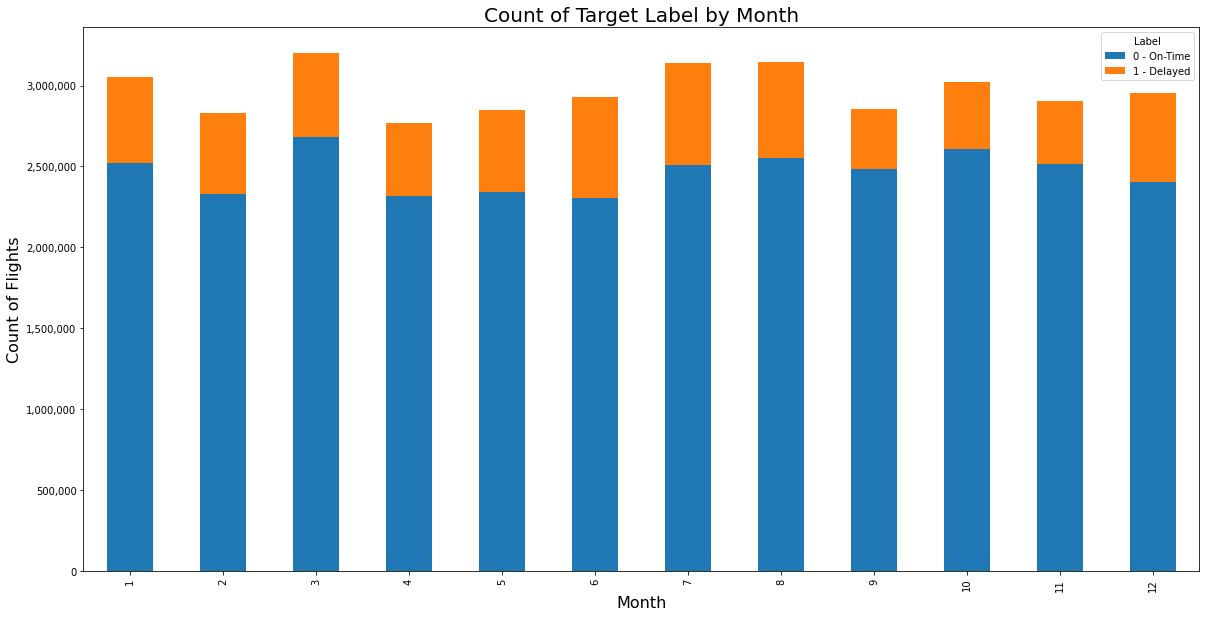

In [0]:
def l_month(df):

  df1 = df.groupBy('MONTH', 'label').count().orderBy('MONTH').selectExpr('MONTH AS Month', 'label AS Label', 'count AS Count') \
          .withColumn('Label', regexp_replace('Label', '0', '0 - On-Time')).withColumn('Label', regexp_replace('Label', '1', '1 - Delayed')) \
          .toPandas()
  
  ax = df1.pivot_table(index = 'Month', columns = 'Label' , values = 'Count').plot(kind='bar', stacked=True, figsize = (20, 10))
  
  ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
  ax.set_title('Count of Target Label by Month', fontsize = 20)
  ax.set_xlabel("Month", fontsize = 16)
  ax.set_ylabel("Count of Flights", fontsize = 16)

  return plt.show()

l_month(df)

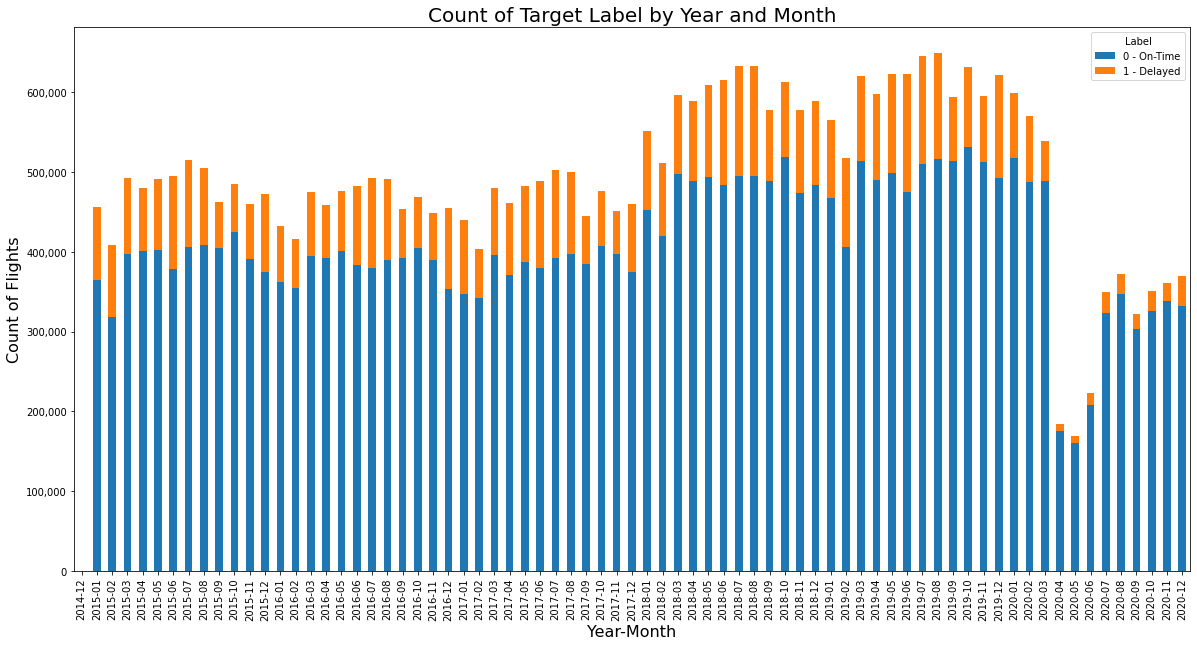

In [0]:
def l_month(df):

  df1 = df.select(date_format('scheduled_departure_UTC', 'yyyy-MM').alias('Year_Month'), 'label') \
          .groupBy('Year_Month', 'label').count().orderBy('Year_Month').selectExpr('Year_Month', 'label AS Label', 'count AS Count') \
          .withColumn('Label', regexp_replace('Label', '0', '0 - On-Time')).withColumn('Label', regexp_replace('Label', '1', '1 - Delayed')) \
          .toPandas()
  
  ax = df1.pivot_table(index = 'Year_Month', columns = 'Label' , values = 'Count').plot(kind='bar', stacked=True, figsize = (20, 10))
  
  ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
  ax.set_title('Count of Target Label by Year and Month', fontsize = 20)
  ax.set_xlabel("Year-Month", fontsize = 16)
  ax.set_ylabel("Count of Flights", fontsize = 16)

  return plt.show()

l_month(df)

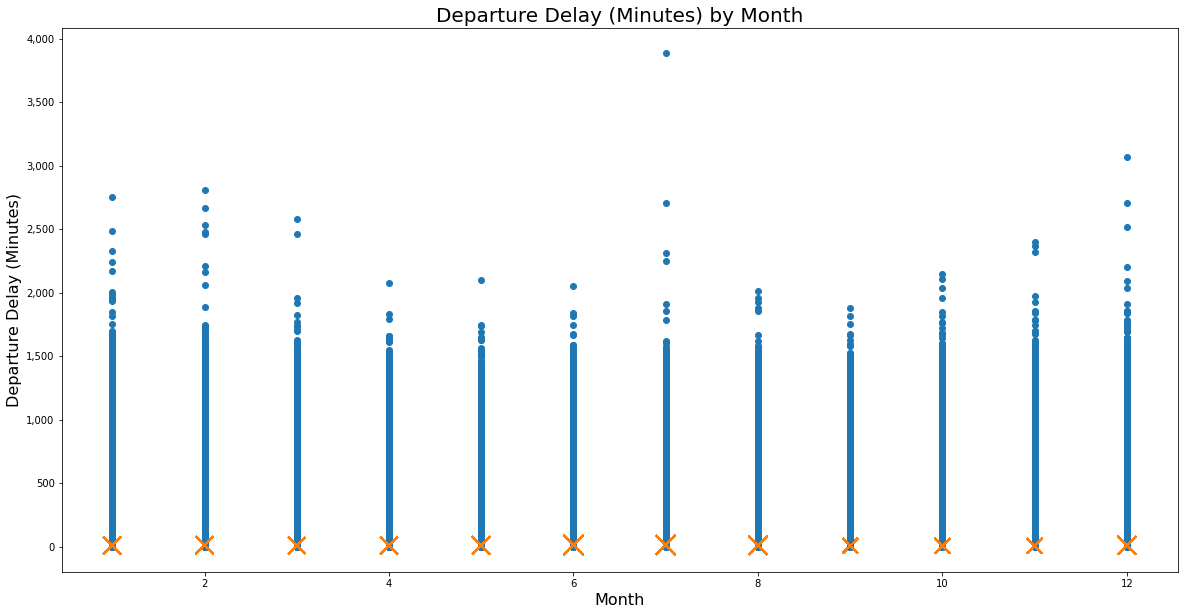

MONTH,Median_Per_Month
12,"List(0, 0, 7)"
1,"List(0, 0, 6)"
6,"List(0, 0, 10)"
3,"List(0, 0, 5)"
5,"List(0, 0, 6)"
9,"List(0, 0, 1)"
4,"List(0, 0, 4)"
8,"List(0, 0, 7)"
7,"List(0, 0, 8)"
10,"List(0, 0, 2)"


Out[14]: (None, None)

In [0]:
def d_month(df):

  df1 = df.groupBy('MONTH', 'DEP_DELAY_NEW').count().orderBy('MONTH') \
          .selectExpr('MONTH AS Month', 'DEP_DELAY_NEW AS Departure_Delay_Minutes', 'count AS Count')
  
  df2 = df.select('MONTH', 'DEP_DELAY_NEW').groupBy('MONTH').mean().orderBy('MONTH').withColumnRenamed('avg(DEP_DELAY_NEW)',"Avg_Per_Month") \
          .selectExpr('MONTH AS Month', 'Avg_Per_Month')
  
  df3 = df1.join(df2,['Month']).orderBy('Month').toPandas()
  
  percentiles = df.select('MONTH', 'DEP_DELAY_NEW').groupBy('MONTH').agg(f.percentile_approx("DEP_DELAY_NEW", [0.25,0.5,0.75]).alias("Median_Per_Month"))
  
  fig = plt.figure(figsize=(20, 10))
  ax = fig.add_subplot(111)
  plt.scatter(x = df3['Month'],  y = df3['Departure_Delay_Minutes'])
  plt.scatter(x = df3['Month'],  y = df3['Avg_Per_Month'], marker = 'x', s=df3['Avg_Per_Month']*25)
    
  ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
  ax.set_title('Departure Delay (Minutes) by Month', fontsize = 20)
  ax.set_xlabel("Month", fontsize = 16)
  ax.set_ylabel("Departure Delay (Minutes)", fontsize = 16)

  return plt.show(), display(percentiles)

d_month(df)


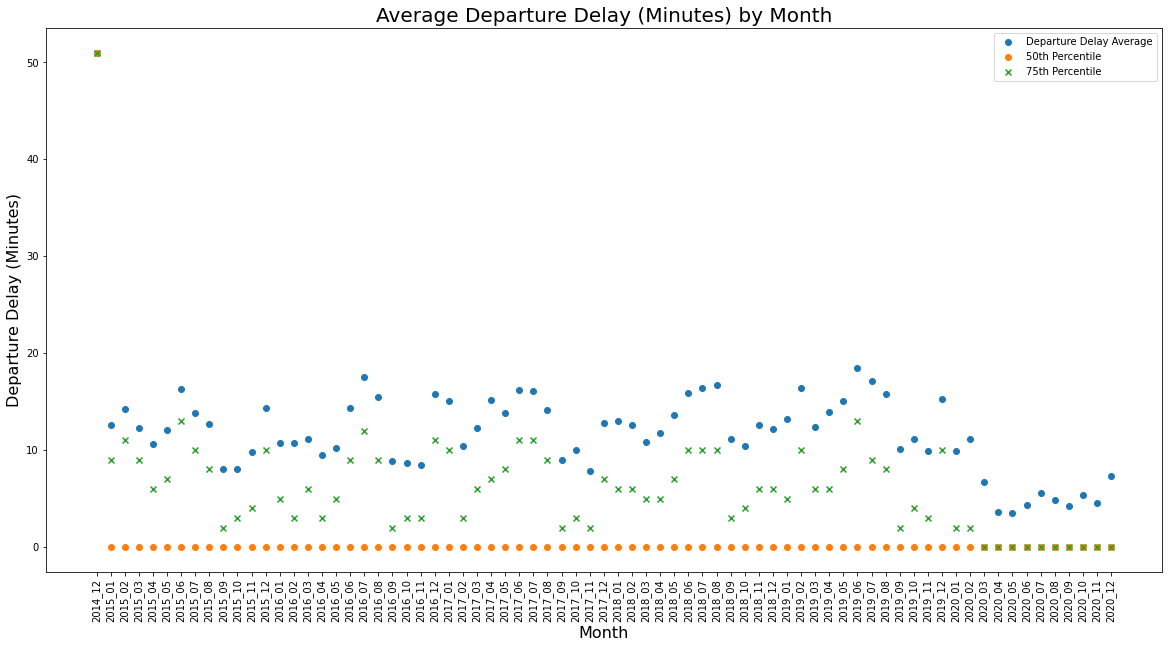

In [0]:
def d_month(df):
  
  df2 = df.select(date_format('scheduled_departure_UTC', 'yyyy_MM').alias('Year_Month'), 'DEP_DELAY_NEW') \
          .groupBy('Year_Month').mean().orderBy('Year_Month').withColumnRenamed('avg(DEP_DELAY_NEW)',"Avg_Per_Month") \
          .select('Year_Month', 'Avg_Per_Month').toPandas()  

  percentile_1 = df.select(date_format('scheduled_departure_UTC', 'yyyy_MM').alias('Year_Month'), 'DEP_DELAY_NEW') \
                   .groupBy('Year_Month').agg(f.percentile_approx("DEP_DELAY_NEW", [0.50]).alias("Percentile_50th")) \
                   .withColumn("Percentile_50th", col("Percentile_50th").getItem(0)).toPandas()
    
  percentile_2 = df.select(date_format('scheduled_departure_UTC', 'yyyy_MM').alias('Year_Month'), 'DEP_DELAY_NEW') \
                   .groupBy('Year_Month').agg(f.percentile_approx("DEP_DELAY_NEW", [0.75]).alias("Percentile_75th")) \
                   .withColumn("Percentile_75th", col("Percentile_75th").getItem(0)).toPandas()
  
  fig = plt.figure(figsize=(20, 10))
  ax = fig.add_subplot(111)
  ax.scatter(x = df2['Year_Month'],  y = df2['Avg_Per_Month'], label = 'Departure Delay Average')
  
  ax.scatter(x = percentile_1['Year_Month'],  y = percentile_1['Percentile_50th'], marker = 'o', label = '50th Percentile')
  ax.scatter(x = percentile_2['Year_Month'],  y = percentile_2['Percentile_75th'], marker = 'x', label = '75th Percentile')
    
  ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
  ax.set_title('Average Departure Delay (Minutes) by Month', fontsize = 20)
  ax.set_xlabel("Month", fontsize = 16)
  ax.set_ylabel("Departure Delay (Minutes)", fontsize = 16)
  ax.legend()
  
  plt.xticks(rotation = 90)

  return plt.show()

d_month(df)

#   ax2 = ax.twinx()
#   plt.scatter(x = df3['Year_Month'],  y = df3['Avg_Per_Month'], marker = 'x', s=df3['Avg_Per_Month']*25)

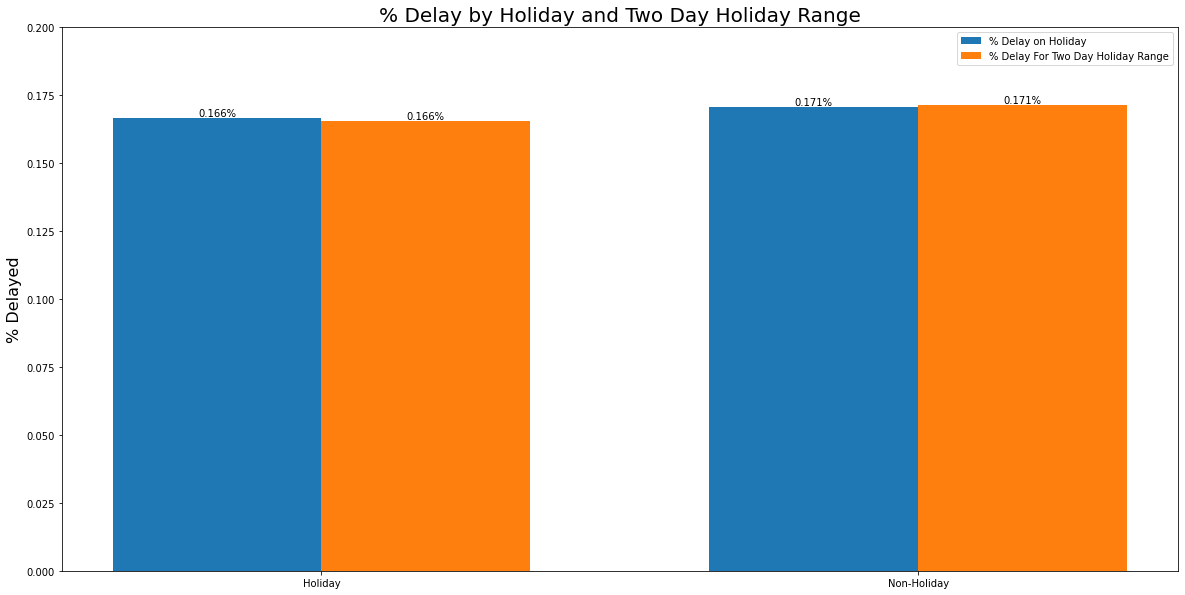

In [0]:
def l_2dayholiday(df):
  
  all_records = df.select('holiday_in2DayRange', 'label').groupBy('holiday_in2DayRange').count() \
                  .selectExpr('holiday_in2DayRange AS Holiday', 'count AS Count_All') \
                  .withColumn('Holiday', regexp_replace('Holiday', '0', 'Non-Holiday')) \
                  .withColumn('Holiday', regexp_replace('Holiday', '1', 'Holiday')) 
                  
  delayed = df.select('holiday_in2DayRange', 'label').filter("label == '1'").groupBy('holiday_in2DayRange').count() \
              .selectExpr('holiday_in2DayRange AS Holiday', 'count AS Count_Delayed') \
              .withColumn('Holiday', regexp_replace('Holiday', '0', 'Non-Holiday')) \
              .withColumn('Holiday', regexp_replace('Holiday', '1', 'Holiday'))           
                   
  df1 = all_records.join(delayed,['Holiday']).withColumn('Pct_Delayed_Two_Day_Holiday_Range', (f.col('Count_Delayed') / f.col('Count_All'))) \
                   .select('Holiday', 'Pct_Delayed_Two_Day_Holiday_Range')
  
  
  all_records1 = df.select('holiday', 'label').groupBy('holiday').count().selectExpr('holiday AS Holiday', 'count AS Count_All') \
                  .withColumn('Holiday', regexp_replace('Holiday', '0', 'Non-Holiday')).withColumn('Holiday', regexp_replace('Holiday', '1', 'Holiday')) 
                 
  delayed1 = df.select('holiday', 'label').filter("label == '1'").groupBy('holiday').count() \
              .selectExpr('holiday AS Holiday', 'count AS Count_Delayed') \
              .withColumn('Holiday', regexp_replace('Holiday', '0', 'Non-Holiday')).withColumn('Holiday', regexp_replace('Holiday', '1', 'Holiday'))   
  
  df2 = all_records1.join(delayed1,['Holiday']).withColumn('Pct_Delayed_Holiday', (f.col('Count_Delayed') / f.col('Count_All'))) \
                    .select('Holiday', 'Pct_Delayed_Holiday')
                  
  df3 = df2.join(df1,['Holiday']).toPandas()
  
  labels = ['Holiday', 'Non-Holiday']
  x = np.arange(len(labels))  # the label locations
  width = 0.35  # the width of the bars

  fig = plt.figure(figsize=(20, 10))
  ax = fig.add_subplot(111)
  ax.bar(x - width/2, df3['Pct_Delayed_Holiday'], width, label='% Delay on Holiday')
  ax.bar(x + width/2, df3['Pct_Delayed_Two_Day_Holiday_Range'], width, label='% Delay For Two Day Holiday Range')
  ax.set_ylabel("% Delayed", fontsize = 16)
  ax.set_title('% Delay by Holiday and Two Day Holiday Range', fontsize = 20)
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.bar_label(ax.containers[0], label_type='edge', fmt='%.3f%%')
  ax.bar_label(ax.containers[1], label_type='edge', fmt='%.3f%%')
  ax.set_ylim([0, 0.2])

  ax.legend()

  return plt.show()

l_2dayholiday(df)

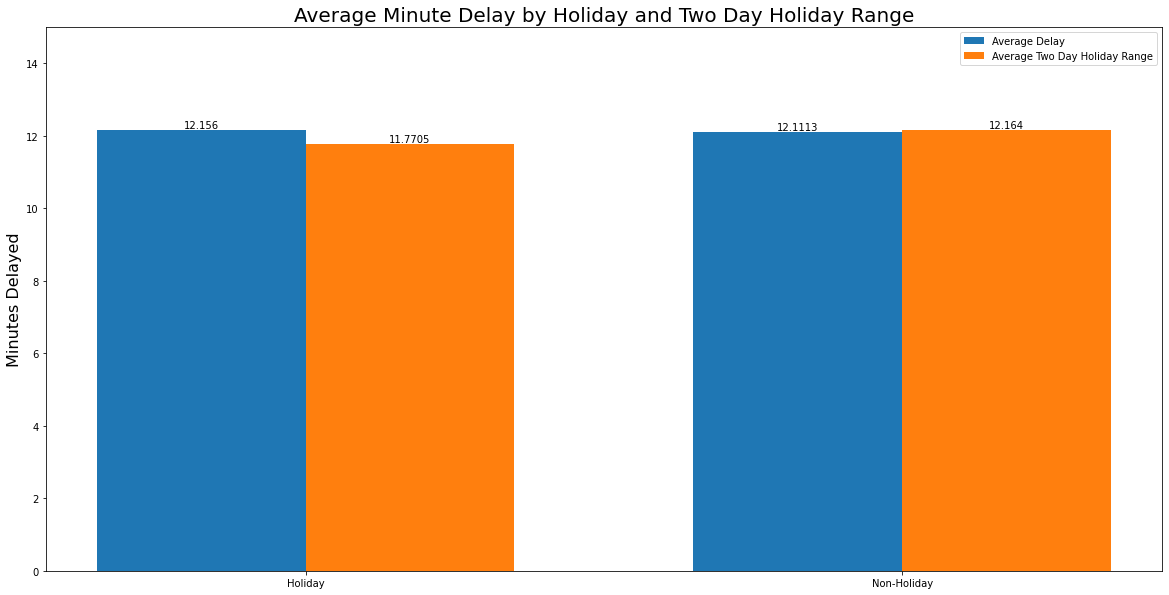

In [0]:
def l_holiday(df):
  
  holidays = df.select('holiday', 'DEP_DELAY_NEW').groupBy('holiday').mean().withColumnRenamed('avg(DEP_DELAY_NEW)',"Avg_Delay") \
               .withColumnRenamed('holiday',"Holiday").select('Holiday', 'Avg_Delay') \
               .withColumn('Holiday', regexp_replace('Holiday', '0', 'Non-Holiday')).withColumn('Holiday', regexp_replace('Holiday', '1', 'Holiday'))
  
  two_day_range = df.select('holiday_in2DayRange', 'DEP_DELAY_NEW').groupBy('holiday_in2DayRange').mean() \
                    .withColumnRenamed('avg(DEP_DELAY_NEW)',"Avg_Delay_Two_Day_Range") \
                    .withColumnRenamed('holiday_in2DayRange',"Holiday").select('Holiday', 'Avg_Delay_Two_Day_Range') \
                    .withColumn('Holiday', regexp_replace('Holiday', '0', 'Non-Holiday')).withColumn('Holiday', regexp_replace('Holiday', '1', 'Holiday'))

  df1 = holidays.join(two_day_range,['Holiday']).toPandas() 
  
  labels = ['Holiday', 'Non-Holiday']
  x = np.arange(len(labels))  # the label locations
  width = 0.35  # the width of the bars

  fig = plt.figure(figsize=(20, 10))
  ax = fig.add_subplot(111)
  ax.bar(x - width/2, df1['Avg_Delay'], width, label='Average Delay')
  ax.bar(x + width/2, df1['Avg_Delay_Two_Day_Range'], width, label='Average Two Day Holiday Range')
  ax.set_ylabel("Minutes Delayed", fontsize = 16)
  ax.set_title('Average Minute Delay by Holiday and Two Day Holiday Range', fontsize = 20)
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.bar_label(ax.containers[0], label_type='edge')
  ax.bar_label(ax.containers[1], label_type='edge')
  ax.set_ylim([0, 15])

  ax.legend()

  return plt.show()

l_holiday(df)

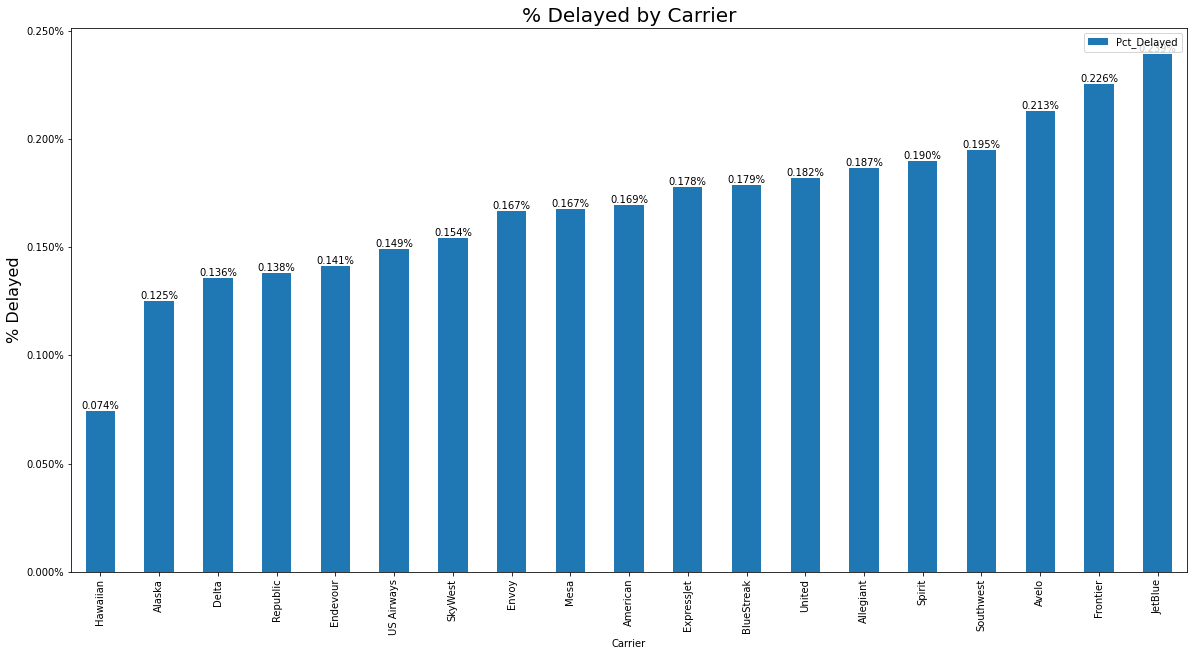

In [0]:
def l_airline(df):
  
  all_records = df.select('OP_UNIQUE_CARRIER', 'label').groupBy('OP_UNIQUE_CARRIER').count() \
                  .selectExpr('OP_UNIQUE_CARRIER AS Carrier', 'count AS Count_All')
  
  delayed = df.select('OP_UNIQUE_CARRIER', 'label').filter("label == '1'").groupBy('OP_UNIQUE_CARRIER').count() \
              .selectExpr('OP_UNIQUE_CARRIER AS Carrier', 'count AS Count_Delayed') 
                   
  df1 = all_records.join(delayed,['Carrier']).withColumn('Pct_Delayed', (f.col('Count_Delayed') / f.col('Count_All'))) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'HA', 'Hawaiian')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'UA', 'United')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'AA', 'American')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'EV', 'ExpressJet')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'NK', 'Spirit')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'B6', 'JetBlue')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'DL', 'Delta')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'F9', 'Frontier')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'YB', 'AirShuttle')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'US', 'US Airways')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'MQ', 'Envoy')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'OO', 'SkyWest')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'G4', 'Allegiant')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'VX', 'Avelo')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'AS', 'Alaska')) \
                   .withColumn('Carrier', regexp_replace('Carrier', '9E', 'Endevour')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'WN', 'Southwest')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'YX', 'Republic')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'OH', 'BlueStreak')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'YV', 'Mesa')) \
                   .select('Carrier', 'Pct_Delayed').orderBy('Pct_Delayed').toPandas()
  
  ax = df1.plot(kind='bar', x='Carrier', y='Pct_Delayed', stacked=False, figsize = (20, 10)) 
  ax.set_title('% Delayed by Carrier', fontsize = 20)
  ax.set_ylabel("% Delayed", fontsize = 16)
  ax.yaxis.set_major_formatter(mtick.PercentFormatter())
  ax.bar_label(ax.containers[0], label_type='edge', fmt='%.3f%%')

  return plt.show()

l_airline(df)

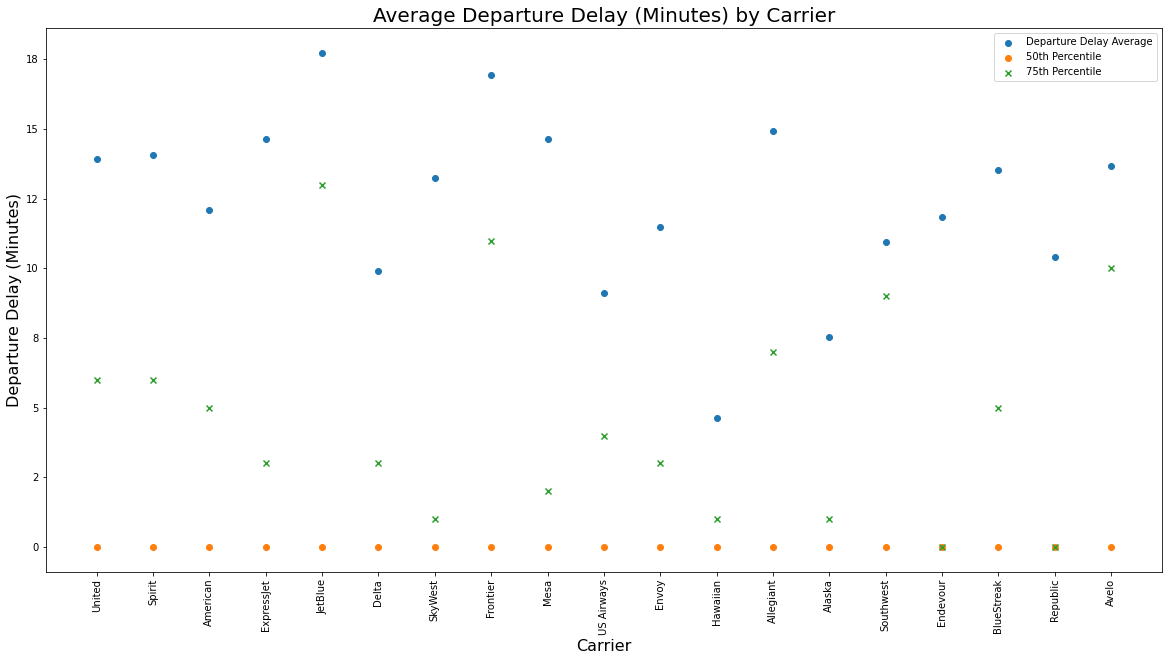

In [0]:
def d_carrier(df):
  
  df2 = df.select('OP_UNIQUE_CARRIER', 'DEP_DELAY_NEW') \
          .groupBy('OP_UNIQUE_CARRIER').mean().withColumnRenamed('avg(DEP_DELAY_NEW)',"Avg_Per_Carrier") \
          .withColumnRenamed('OP_UNIQUE_CARRIER',"Carrier") \
          .withColumn('Carrier', regexp_replace('Carrier', 'HA', 'Hawaiian')) \
          .withColumn('Carrier', regexp_replace('Carrier', 'UA', 'United')) \
          .withColumn('Carrier', regexp_replace('Carrier', 'AA', 'American')) \
          .withColumn('Carrier', regexp_replace('Carrier', 'EV', 'ExpressJet')) \
          .withColumn('Carrier', regexp_replace('Carrier', 'NK', 'Spirit')) \
          .withColumn('Carrier', regexp_replace('Carrier', 'B6', 'JetBlue')) \
          .withColumn('Carrier', regexp_replace('Carrier', 'DL', 'Delta')) \
          .withColumn('Carrier', regexp_replace('Carrier', 'F9', 'Frontier')) \
          .withColumn('Carrier', regexp_replace('Carrier', 'YB', 'AirShuttle')) \
          .withColumn('Carrier', regexp_replace('Carrier', 'US', 'US Airways')) \
          .withColumn('Carrier', regexp_replace('Carrier', 'MQ', 'Envoy')) \
          .withColumn('Carrier', regexp_replace('Carrier', 'OO', 'SkyWest')) \
          .withColumn('Carrier', regexp_replace('Carrier', 'G4', 'Allegiant')) \
          .withColumn('Carrier', regexp_replace('Carrier', 'VX', 'Avelo')) \
          .withColumn('Carrier', regexp_replace('Carrier', 'AS', 'Alaska')) \
          .withColumn('Carrier', regexp_replace('Carrier', '9E', 'Endevour')) \
          .withColumn('Carrier', regexp_replace('Carrier', 'WN', 'Southwest')) \
          .withColumn('Carrier', regexp_replace('Carrier', 'YX', 'Republic')) \
          .withColumn('Carrier', regexp_replace('Carrier', 'YV', 'Mesa')) \
          .withColumn('Carrier', regexp_replace('Carrier', 'OH', 'BlueStreak')) \
          .select('Carrier', 'Avg_Per_Carrier').toPandas()  

  percentile_1 = df.select('OP_UNIQUE_CARRIER', 'DEP_DELAY_NEW') \
                   .groupBy('OP_UNIQUE_CARRIER').agg(f.percentile_approx("DEP_DELAY_NEW", [0.50]).alias("Percentile_50th")) \
                   .withColumn("Percentile_50th", col("Percentile_50th").getItem(0)) \
                   .withColumnRenamed('OP_UNIQUE_CARRIER',"Carrier") \
                   .withColumn('Carrier', regexp_replace('Carrier', 'HA', 'Hawaiian')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'UA', 'United')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'AA', 'American')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'EV', 'ExpressJet')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'NK', 'Spirit')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'B6', 'JetBlue')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'DL', 'Delta')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'F9', 'Frontier')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'YB', 'AirShuttle')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'US', 'US Airways')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'MQ', 'Envoy')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'OO', 'SkyWest')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'G4', 'Allegiant')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'VX', 'Avelo')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'AS', 'Alaska')) \
                   .withColumn('Carrier', regexp_replace('Carrier', '9E', 'Endevour')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'WN', 'Southwest')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'YX', 'Republic')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'YV', 'Mesa')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'OH', 'BlueStreak')).toPandas()

  percentile_2 = df.select('OP_UNIQUE_CARRIER', 'DEP_DELAY_NEW') \
                   .groupBy('OP_UNIQUE_CARRIER').agg(f.percentile_approx("DEP_DELAY_NEW", [0.75]).alias("Percentile_75th")) \
                   .withColumn("Percentile_75th", col("Percentile_75th").getItem(0)) \
                   .withColumnRenamed('OP_UNIQUE_CARRIER',"Carrier") \
                   .withColumn('Carrier', regexp_replace('Carrier', 'HA', 'Hawaiian')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'UA', 'United')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'AA', 'American')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'EV', 'ExpressJet')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'NK', 'Spirit')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'B6', 'JetBlue')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'DL', 'Delta')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'F9', 'Frontier')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'YB', 'AirShuttle')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'US', 'US Airways')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'MQ', 'Envoy')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'OO', 'SkyWest')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'G4', 'Allegiant')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'VX', 'Avelo')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'AS', 'Alaska')) \
                   .withColumn('Carrier', regexp_replace('Carrier', '9E', 'Endevour')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'WN', 'Southwest')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'YX', 'Republic')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'YV', 'Mesa')) \
                   .withColumn('Carrier', regexp_replace('Carrier', 'OH', 'BlueStreak')).toPandas()
  
  fig = plt.figure(figsize=(20, 10))
  ax = fig.add_subplot(111)
  ax.scatter(x = df2['Carrier'],  y = df2['Avg_Per_Carrier'], label = 'Departure Delay Average')
  
  ax.scatter(x = percentile_1['Carrier'],  y = percentile_1['Percentile_50th'], marker = 'o', label = '50th Percentile')
  ax.scatter(x = percentile_2['Carrier'],  y = percentile_2['Percentile_75th'], marker = 'x', label = '75th Percentile')
    
  ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
  ax.set_title('Average Departure Delay (Minutes) by Carrier', fontsize = 20)
  ax.set_xlabel("Carrier", fontsize = 16)
  ax.set_ylabel("Departure Delay (Minutes)", fontsize = 16)
  ax.legend()
  
  plt.xticks(rotation = 90)

  return plt.show()

d_carrier(df)

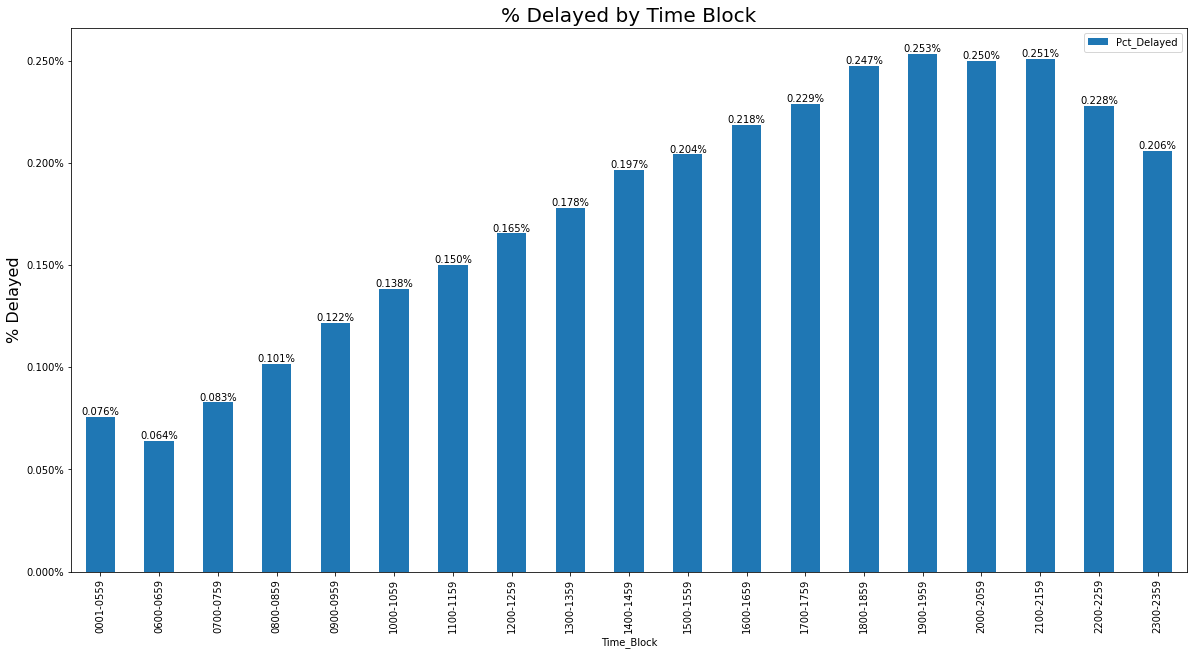

Time_Block,Pct_Delayed
0001-0559,0.07553330891447797
0600-0659,0.06384881696526391
0700-0759,0.08280519142890169
0800-0859,0.10145759061588483
0900-0959,0.12164524416823395
1000-1059,0.138317581385563
1100-1159,0.14995768165006781
1200-1259,0.16541131529519265
1300-1359,0.17798505229434888
1400-1459,0.19651183395240346


Out[177]: (None, None)

In [0]:
def l_time(df):
  
  all_records = df.select('DEP_TIME_BLK', 'label').groupBy('DEP_TIME_BLK').count() \
                  .selectExpr('DEP_TIME_BLK AS Time_Block', 'count AS Count_All')
  
  delayed = df.select('DEP_TIME_BLK', 'label').filter("label == '1'").groupBy('DEP_TIME_BLK').count() \
              .selectExpr('DEP_TIME_BLK AS Time_Block', 'count AS Count_Delayed') 
                   
  df1 = all_records.join(delayed,['Time_Block']).withColumn('Pct_Delayed', (f.col('Count_Delayed') / f.col('Count_All'))) \
                   .select('Time_Block', 'Pct_Delayed').orderBy('Time_Block').toPandas()
  
  ax = df1.plot(kind='bar', x='Time_Block', y='Pct_Delayed', stacked=False, figsize = (20, 10)) 
  ax.set_title('% Delayed by Time Block', fontsize = 20)
  ax.set_ylabel("% Delayed", fontsize = 16)
  ax.yaxis.set_major_formatter(mtick.PercentFormatter())
  ax.bar_label(ax.containers[0], label_type='edge', fmt='%.3f%%')

  return plt.show(), display(df1)

l_time(df)

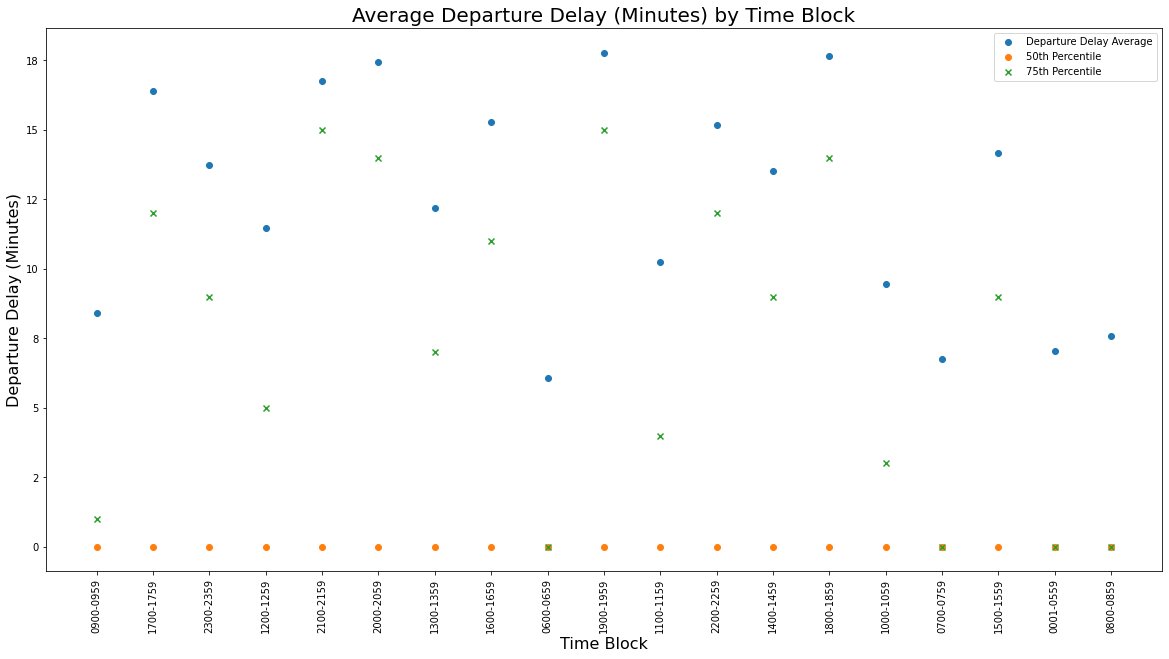

In [0]:
def d_time_block(df):
  
  df2 = df.select('DEP_TIME_BLK', 'DEP_DELAY_NEW') \
          .groupBy('DEP_TIME_BLK').mean().withColumnRenamed('avg(DEP_DELAY_NEW)',"Avg_Per_Time_Block") \
          .withColumnRenamed('DEP_TIME_BLK',"Time_Block") \
          .select('Time_Block', 'Avg_Per_Time_Block').toPandas()  

  percentile_1 = df.select('DEP_TIME_BLK', 'DEP_DELAY_NEW') \
                   .groupBy('DEP_TIME_BLK').agg(f.percentile_approx("DEP_DELAY_NEW", [0.50]).alias("Percentile_50th")) \
                   .withColumn("Percentile_50th", col("Percentile_50th").getItem(0)) \
                   .withColumnRenamed('DEP_TIME_BLK',"Time_Block").toPandas()

  percentile_2 = df.select('DEP_TIME_BLK', 'DEP_DELAY_NEW') \
                   .groupBy('DEP_TIME_BLK').agg(f.percentile_approx("DEP_DELAY_NEW", [0.75]).alias("Percentile_75th")) \
                   .withColumn("Percentile_75th", col("Percentile_75th").getItem(0)) \
                   .withColumnRenamed('DEP_TIME_BLK',"Time_Block").toPandas()
  
  fig = plt.figure(figsize=(20, 10))
  ax = fig.add_subplot(111)
  ax.scatter(x = df2['Time_Block'],  y = df2['Avg_Per_Time_Block'], label = 'Departure Delay Average')
  
  ax.scatter(x = percentile_1['Time_Block'],  y = percentile_1['Percentile_50th'], marker = 'o', label = '50th Percentile')
  ax.scatter(x = percentile_2['Time_Block'],  y = percentile_2['Percentile_75th'], marker = 'x', label = '75th Percentile')
    
  ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
  ax.set_title('Average Departure Delay (Minutes) by Time Block', fontsize = 20)
  ax.set_xlabel("Time Block", fontsize = 16)
  ax.set_ylabel("Departure Delay (Minutes)", fontsize = 16)
  ax.legend()
  
  plt.xticks(rotation = 90)

  return plt.show()

d_time_block(df)

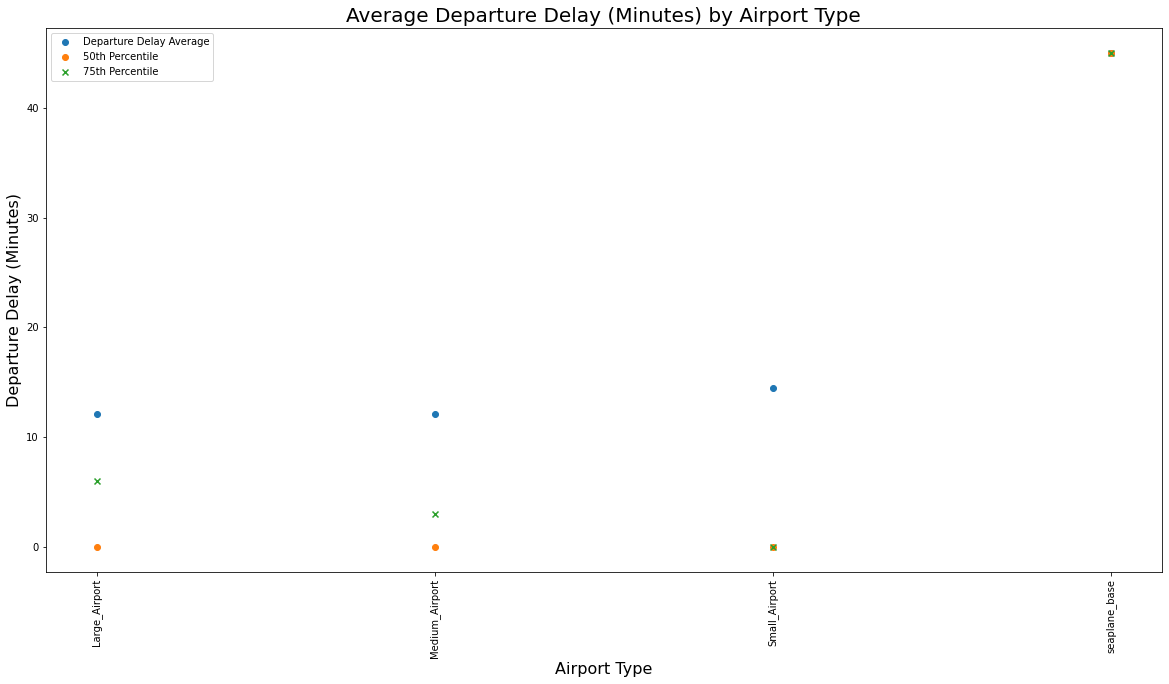

In [0]:
def d_type(df):
  
  df2 = df.select('type', 'DEP_DELAY_NEW') \
          .groupBy('type').mean().withColumnRenamed('avg(DEP_DELAY_NEW)',"Avg_Per_Type") \
          .withColumnRenamed('type',"Airport_Type") \
          .withColumn('Airport_Type', regexp_replace('Airport_Type', 'small_airport', 'Small_Airport')) \
          .withColumn('Airport_Type', regexp_replace('Airport_Type', 'large_airport', 'Large_Airport')) \
          .withColumn('Airport_Type', regexp_replace('Airport_Type', 'medium_airport', 'Medium_Airport')) \
          .select('Airport_Type', 'Avg_Per_Type').toPandas()  

  percentile_1 = df.select('type', 'DEP_DELAY_NEW') \
                   .groupBy('type').agg(f.percentile_approx("DEP_DELAY_NEW", [0.50]).alias("Percentile_50th")) \
                   .withColumn("Percentile_50th", col("Percentile_50th").getItem(0)) \
                   .withColumnRenamed('type',"Airport_Type") \
                   .withColumn('Airport_Type', regexp_replace('Airport_Type', 'small_airport', 'Small_Airport')) \
                   .withColumn('Airport_Type', regexp_replace('Airport_Type', 'large_airport', 'Large_Airport')) \
                   .withColumn('Airport_Type', regexp_replace('Airport_Type', 'medium_airport', 'Medium_Airport')).toPandas()

  percentile_2 = df.select('type', 'DEP_DELAY_NEW') \
                   .groupBy('type').agg(f.percentile_approx("DEP_DELAY_NEW", [0.75]).alias("Percentile_75th")) \
                   .withColumn("Percentile_75th", col("Percentile_75th").getItem(0)) \
                   .withColumnRenamed('type',"Airport_Type") \
                   .withColumn('Airport_Type', regexp_replace('Airport_Type', 'small_airport', 'Small_Airport')) \
                   .withColumn('Airport_Type', regexp_replace('Airport_Type', 'large_airport', 'Large_Airport')) \
                   .withColumn('Airport_Type', regexp_replace('Airport_Type', 'medium_airport', 'Medium_Airport')).toPandas()
  
  fig = plt.figure(figsize=(20, 10))
  ax = fig.add_subplot(111)
  ax.scatter(x = df2['Airport_Type'],  y = df2['Avg_Per_Type'], label = 'Departure Delay Average')
  
  ax.scatter(x = percentile_1['Airport_Type'],  y = percentile_1['Percentile_50th'], marker = 'o', label = '50th Percentile')
  ax.scatter(x = percentile_2['Airport_Type'],  y = percentile_2['Percentile_75th'], marker = 'x', label = '75th Percentile')
    
  ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
  ax.set_title('Average Departure Delay (Minutes) by Airport Type', fontsize = 20)
  ax.set_xlabel("Airport Type", fontsize = 16)
  ax.set_ylabel("Departure Delay (Minutes)", fontsize = 16)
  ax.legend()
  
  plt.xticks(rotation = 90)

  return plt.show()

d_type(df)

### Garbage Collection

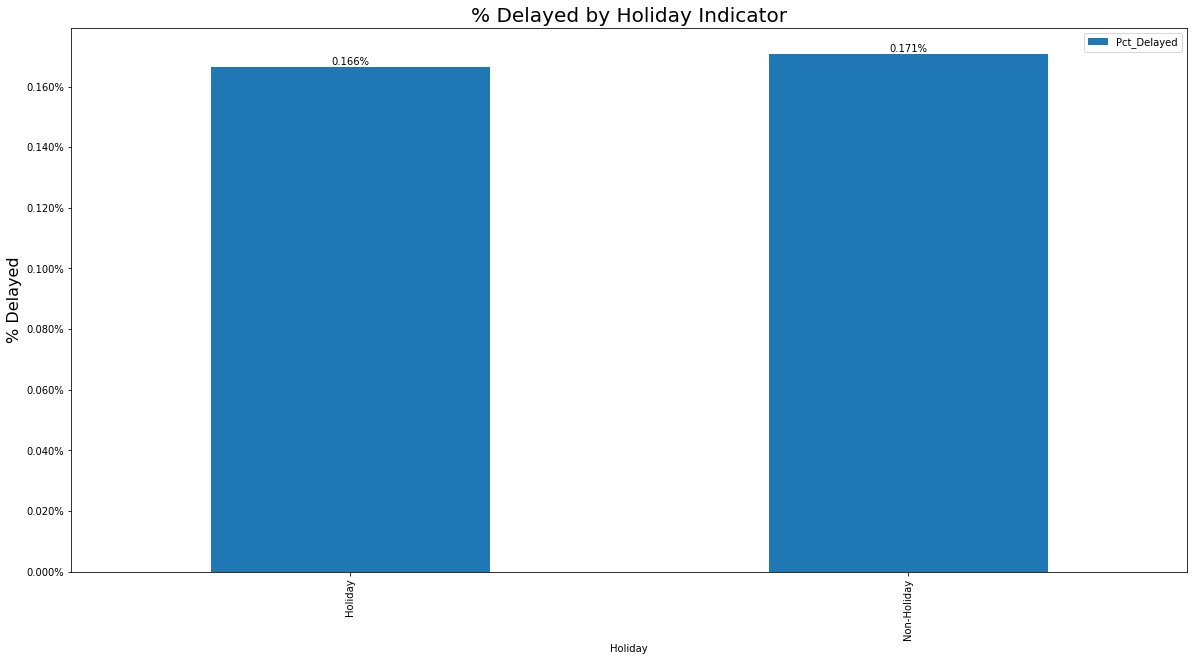

Holiday,Count_All,Count_Delayed,Pct_Delayed
Holiday,926784,154289,0.16647784165458188
Non-Holiday,34722427,5928281,0.17073348588219367


Out[93]: (None, None)

In [0]:
# def l_holiday(df):
  
#   all_records = df.select('holiday', 'label').groupBy('holiday').count().selectExpr('holiday AS Holiday', 'count AS Count_All') \
#                   .withColumn('Holiday', regexp_replace('Holiday', '0', 'Non-Holiday')).withColumn('Holiday', regexp_replace('Holiday', '1', 'Holiday')) 
                
  
#   delayed = df.select('holiday', 'label').filter("label == '1'").groupBy('holiday').count() \
#               .selectExpr('holiday AS Holiday', 'count AS Count_Delayed') \
#               .withColumn('Holiday', regexp_replace('Holiday', '0', 'Non-Holiday')).withColumn('Holiday', regexp_replace('Holiday', '1', 'Holiday'))
              
                   
#   df1 = all_records.join(delayed,['Holiday']).withColumn('Pct_Delayed', (f.col('Count_Delayed') / f.col('Count_All'))).toPandas()
  
#   ax = df1.plot(kind='bar', x='Holiday', y='Pct_Delayed', stacked=False, figsize = (20, 10)) 
#   ax.set_title('% Delayed by Holiday Indicator', fontsize = 20)
#   ax.set_ylabel("% Delayed", fontsize = 16)
#   ax.yaxis.set_major_formatter(mtick.PercentFormatter())
#   ax.bar_label(ax.containers[0], label_type='edge', fmt='%.3f%%')

#   return plt.show(), display(df1)

# l_holiday(df)

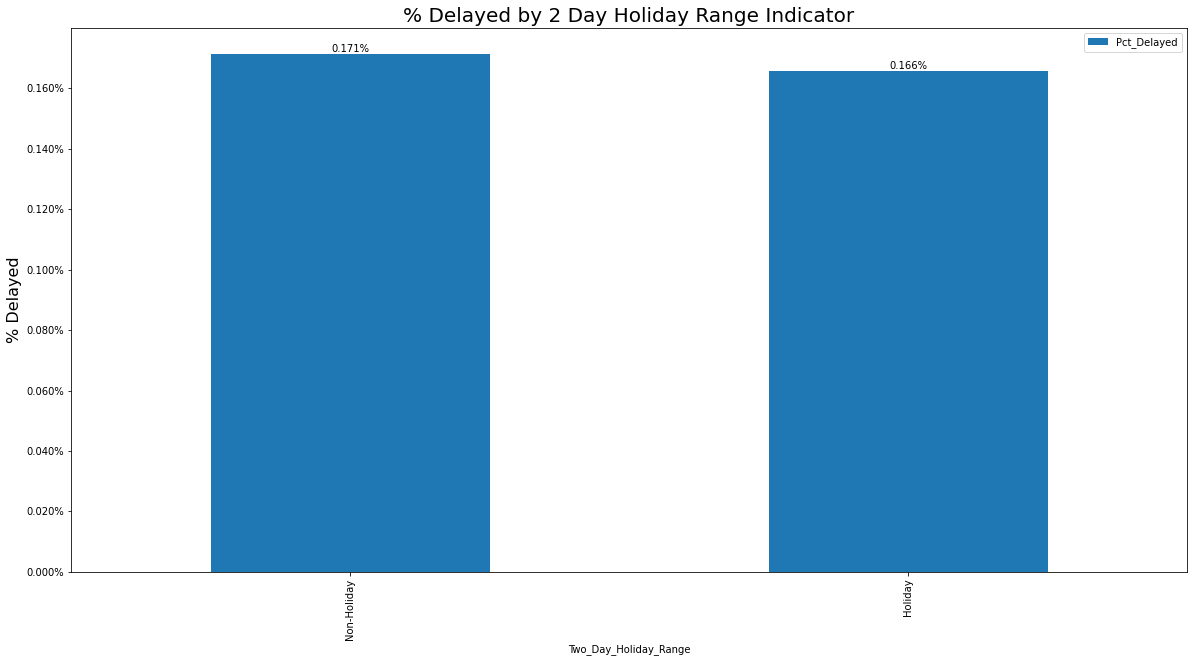

Two_Day_Holiday_Range,Count_All,Count_Delayed,Pct_Delayed
Non-Holiday,30980573,5309283,0.17137459013427545
Holiday,4668638,773287,0.16563438844476697


Out[137]: (None, None)

In [0]:
# def l_2dayholiday(df):
  
#   all_records = df.select('holiday_in2DayRange', 'label').groupBy('holiday_in2DayRange').count() \
#                   .selectExpr('holiday_in2DayRange AS Two_Day_Holiday_Range', 'count AS Count_All') \
#                   .withColumn('Two_Day_Holiday_Range', regexp_replace('Two_Day_Holiday_Range', '0', 'Non-Holiday')) \
#                   .withColumn('Two_Day_Holiday_Range', regexp_replace('Two_Day_Holiday_Range', '1', 'Holiday')) 
                  
#   delayed = df.select('holiday_in2DayRange', 'label').filter("label == '1'").groupBy('holiday_in2DayRange').count() \
#               .selectExpr('holiday_in2DayRange AS Two_Day_Holiday_Range', 'count AS Count_Delayed') \
#               .withColumn('Two_Day_Holiday_Range', regexp_replace('Two_Day_Holiday_Range', '0', 'Non-Holiday')) \
#               .withColumn('Two_Day_Holiday_Range', regexp_replace('Two_Day_Holiday_Range', '1', 'Holiday'))
              
                   
#   df1 = all_records.join(delayed,['Two_Day_Holiday_Range']).withColumn('Pct_Delayed', (f.col('Count_Delayed') / f.col('Count_All'))).toPandas()
  
#   ax = df1.plot(kind='bar', x='Two_Day_Holiday_Range', y='Pct_Delayed', stacked=False, figsize = (20, 10)) 
#   ax.set_title('% Delayed by 2 Day Holiday Range Indicator', fontsize = 20)
#   ax.set_ylabel("% Delayed", fontsize = 16)
#   ax.yaxis.set_major_formatter(mtick.PercentFormatter())
#   ax.bar_label(ax.containers[0], label_type='edge', fmt='%.3f%%')

#   return plt.show(), display(df1)

# l_2dayholiday(df)